<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

# Data

In [2]:
#@title Data parameters
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size =  4#@param {type:"integer"}
num_workers = 2#@param {type:"integer"}

#@tex Data
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualization

In [3]:
def imshow(img):
    img = img /2 + 0.5
    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

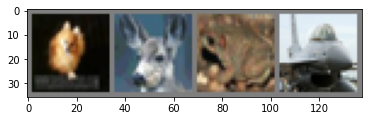

  dog  deer  frog plane


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Convolutional Neural Network

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Calculate size of conv net output layer with [(W−K+2P)/S]+1
        # Parameters of Conv2d: Input Channels, number of filters, filter size
        self.conv1 = nn.Conv2d(3, 8, 3)
        # Output Size: 32-3+1=30
        self.conv2 = nn.Conv2d(8, 16, 3)
        # Output Size: 30-3+1=28
        self.pool = nn.MaxPool2d(2)
        # Output Size: 28/2=14
        self.conv3 = nn.Conv2d(16, 32, 3)
        # Output Size: 14-3+1=12
        self.conv4 = nn.Conv2d(32, 64, 3)
        # Output Size: 12-3+1=10
        # Input of FC is product of output_dim of last conv layer, Kernel Width, Kernel Height
        # Output of FC Layer is number of nodes
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Train

In [6]:
def train():
    print("""
    Epochs (n): {}
    Log interval: {}
    Criterion: {}
    Optimizer: {}
    """.format(learning_rate, momentum, n_epochs, log_interval, criterion, optimizer)
    )
    

    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % log_interval == 0:
                print('[%d, %5d] loss: %.3f' % (epoch +1, i +1, running_loss / log_interval))
                running_loss = 0.0

    print('Finished training')
    torch.save(net.state_dict(), PATH)

#Test

Output on small size

In [8]:
#dataiter = iter(testloader)
#images, labels = dataiter.next()

# print images
#imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#outputs = net(images.to(device))
#_, predicted = torch.max(outputs, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                             for j in range(4)))

In [9]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

# Analyze

In [10]:
def analyze():
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

# Run

## Hyper Parameters

In [11]:
learning_rate = 0.0001#@param {type:"number"}
momentum = 0.9#@param {type:"number"}
n_epochs = 2#@param {type:"integer"}
log_interval = 2000
PATH = './cifar_net.pth'#@param {type:"string"}


In [12]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

## CPU

In [13]:
device = "cpu"
print(device)
net.to(device)

cpu


Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)

In [ ]:
train()


    LR:0.0001
    Momentum: 0.9
    Epochs (n): 2
    Log interval: 2000
    Criterion: CrossEntropyLoss()
    Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
    


In [ ]:
test()

## CUDA

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)